In [1]:
import math
import random
from collections import namedtuple, deque
from itertools import count

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
# Load custom functions
from utils import Params
from environment_tensor import WrappedEnvironment, Actions, CONTEXTS_LABELS, Cues
from agent import Qlearning, EpsilonGreedy
import plotting

In [3]:
# Formatting & autoreload stuff
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [4]:
# Choose the parameters for the task
params = Params(epsilon=0.1, n_runs=1, numEpisodes=50)
params

Params(epsilon=0.1, gamma=0.8, alpha=0.05, jointRep=True, n_runs=1, numEpisodes=50)

In [5]:
# Load the environment
env = WrappedEnvironment(params)

In [6]:
# set up matplotlib
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Replay Memory

We'll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we're going to need two classes:

-  ``Transition`` - a named tuple representing a single transition in
   our environment. It essentially maps (state, action) pairs
   to their (next_state, reward) result, with the state being the
   screen difference image as described later on.
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.




In [7]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))


class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [8]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions, n_units=16):
        super(DQN, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(n_observations, n_units),
            nn.Linear(n_units, n_units),
            nn.Linear(n_units, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_actions),
        )

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        return self.mlp(x)

## Training

### Hyperparameters and utilities
This cell instantiates our model and its optimizer, and defines some
utilities:

-  ``select_action`` - will select an action accordingly to an epsilon
   greedy policy. Simply put, we'll sometimes use our model for choosing
   the action, and sometimes we'll just sample one uniformly. The
   probability of choosing a random action will start at ``EPS_START``
   and will decay exponentially towards ``EPS_END``. ``EPS_DECAY``
   controls the rate of the decay.
-  ``plot_durations`` - a helper for plotting the duration of episodes,
   along with an average over the last 100 episodes (the measure used in
   the official evaluations). The plot will be underneath the cell
   containing the main training loop, and will update after every
   episode.

In [9]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
# n_actions = env.action_space.n
n_actions = env.numActions
# Get the number of state observations
# state, info = env.reset()
state = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(
        -1.0 * steps_done / EPS_DECAY
    )
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            # return policy_net(state).max(1)[1].view(1, 1)
            # return policy_net(state).max().view(1, 1)
            return policy_net(state).argmax().view(1, 1)
    else:
        # return torch.tensor(
        #     [[env.action_space.sample()]], device=device, dtype=torch.long
        # )
        return torch.tensor([[env.action_space.sample()]], device=device)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training...")
    plt.xlabel("Episode")
    plt.ylabel("Duration")
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [10]:
DQN(n_observations, n_actions)

DQN(
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=4, bias=True)
  )
)

### Training loop

Finally, the code for training our model.

Here, you can find an ``optimize_model`` function that performs a
single step of the optimization. It first samples a batch, concatenates
all the tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our
loss. By definition we set $V(s) = 0$ if $s$ is a terminal
state. We also use a target network to compute $V(s_{t+1})$ for
added stability. The target network is updated at every step with a 
[soft update](https://arxiv.org/pdf/1509.02971.pdf)_ controlled by 
the hyperparameter ``TAU``, which was previously defined.




In [11]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device,
        dtype=torch.bool,
    )
    # non_final_next_states = torch.cat(
    #     [s for s in batch.next_state if s is not None]
    # ).unsqueeze(-1)
    non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])
    # state_batch = torch.cat(batch.state)
    # state_batch = torch.cat(batch.state).unsqueeze(-1)
    # action_batch = torch.cat(batch.action)
    state_batch = torch.stack(batch.state)
    action_batch = torch.cat(batch.action).type(torch.int64)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
    return loss.item()

In [12]:
rewards = torch.zeros((params.numEpisodes, params.n_runs), device=device)
steps = torch.zeros((params.numEpisodes, params.n_runs), device=device)
episodes = torch.arange(params.numEpisodes, device=device)
all_states = []
all_actions = []
losses = []

for run in range(params.n_runs):  # Run several times to account for stochasticity
    for episode in tqdm(
        episodes, desc=f"Run {run+1}/{params.n_runs} - Episodes", leave=False
    ):
        state = env.reset()  # Reset the environment
        # state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        # state = torch.tensor(state, device=device).unsqueeze(0)
        # state = state.clone().float().detach().unsqueeze(0)
        state = state.clone().float().detach()
        step_count = 0
        done = False
        total_rewards = 0

        while not done:
            action = select_action(state)

            # # Record states and actions
            all_states.append(state.cpu().numpy()[0])
            all_actions.append(Actions(action.squeeze(0).cpu().numpy()[0]).name)

            observation, reward, done = env.step(action.item(), state)
            reward = torch.tensor([reward], device=device)

            # if terminated:
            if done:
                next_state = None
            else:
                # next_state = torch.tensor(
                #     observation, dtype=torch.float32, device=device
                # ).unsqueeze(0)
                # next_state = observation.clone().float().detach().unsqueeze(0)
                next_state = observation.clone().float().detach()

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            loss = optimize_model()
            losses.append(loss)

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[
                    key
                ] * TAU + target_net_state_dict[key] * (1 - TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                episode_durations.append(step_count + 1)
                # plot_durations()

            total_rewards += reward
            step_count += 1

        rewards[episode, run] = total_rewards
        steps[episode, run] = step_count

In [13]:
env.action_space

In [14]:
[item for item in Actions]

[<Actions.UP: 0>, <Actions.DOWN: 1>, <Actions.LEFT: 2>, <Actions.RIGHT: 3>]

In [15]:
env.tiles_locations.reshape((env.rows, env.cols))

tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24]])

In [16]:
state = env.reset()
state, env.TriangleState

(tensor([20,  0]), <TriangleState.lower: 2>)

In [17]:
observation, reward, done = env.step(action=1, current_state=torch.tensor([19, 2]))
observation, reward, done, env.odor_condition, env.TriangleState

(tensor([24,  2]), 0, False, <OdorCondition.pre: 1>, <TriangleState.lower: 2>)

In [18]:
res = pd.DataFrame(
    data={
        "Episodes": np.tile(episodes.cpu(), reps=params.n_runs),
        "Rewards": rewards.cpu().numpy().flatten(order="F"),
        "Steps": steps.cpu().numpy().flatten(order="F"),
    }
)
res["cum_rewards"] = rewards.cpu().numpy().cumsum(axis=0).flatten(order="F")
res.head(20)

,Episodes,Rewards,Steps,cum_rewards
0,0,0.0,242.0,0.0
1,1,0.0,236.0,0.0
2,2,10.0,119.0,10.0
3,3,0.0,13175.0,10.0
4,4,10.0,688.0,20.0
5,5,0.0,521.0,20.0
6,6,10.0,1052.0,30.0
7,7,0.0,1929.0,30.0
8,8,10.0,15618.0,40.0
9,9,0.0,29328.0,40.0


In [19]:
all_states[:10]

[19.0, 24.0, 24.0, 24.0, 19.0, 14.0, 14.0, 13.0, 12.0, 13.0]

In [20]:
tmp = []
for idx, st in enumerate(tqdm(all_states)):
    tmp.append(env.convert_tensor_state_to_composite(st))
all_state_composite = pd.DataFrame(tmp)
all_state_composite

  0%|                                                                                       | 0/86568 [00:00<?, ?it/s]


IndexError: invalid index to scalar variable.

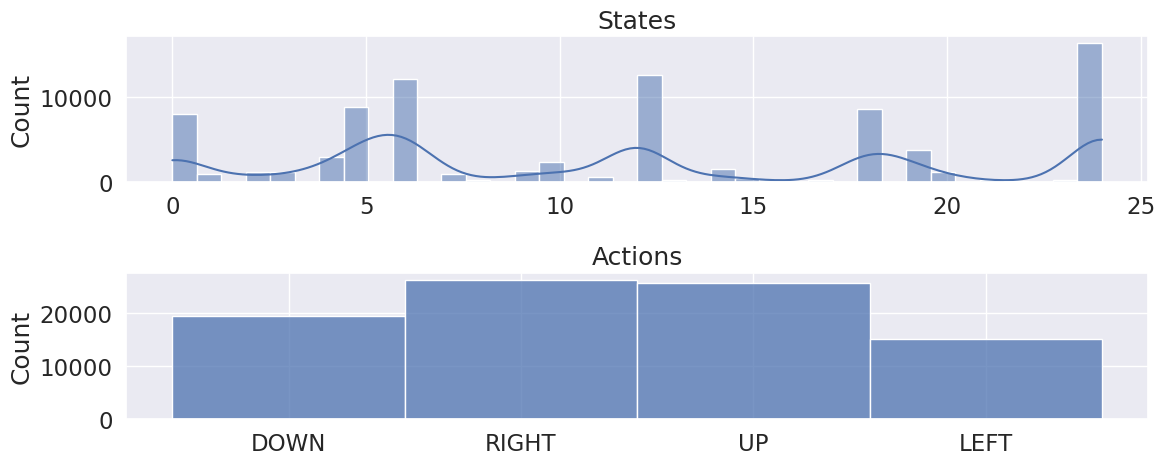

In [22]:
plotting.plot_states_actions_distribution(all_states, all_actions)

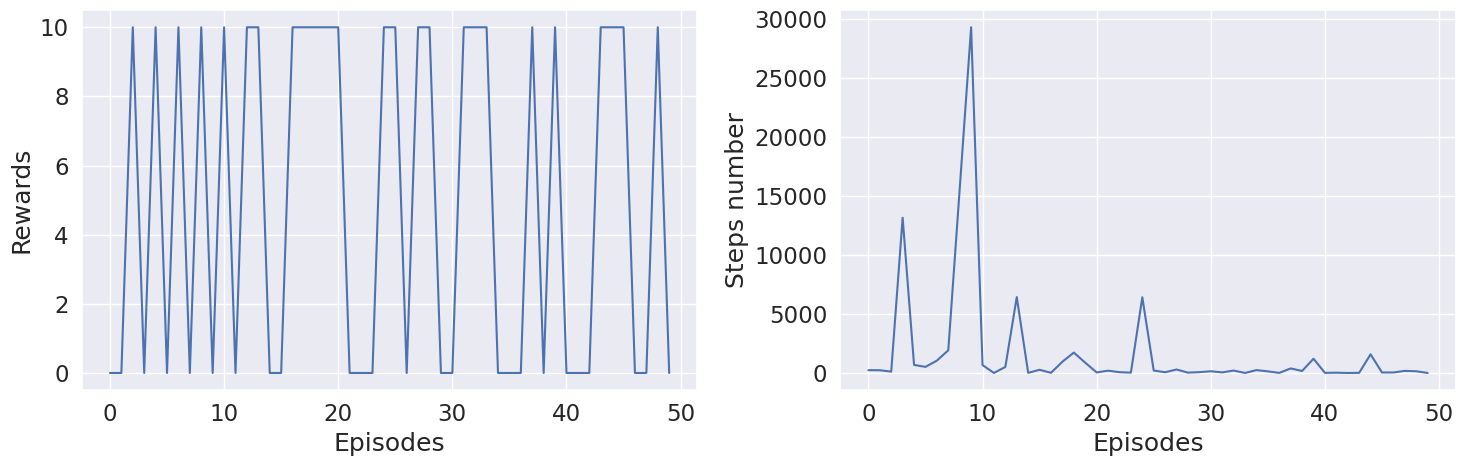

In [23]:
plotting.plot_steps_and_rewards(res)

In [24]:
losses_filt = np.array(list(filter(lambda item: item != None, losses)))
losses_filt

array([1.00011885e-01, 9.84254107e-02, 9.74841863e-02, ...,
       2.83360496e-05, 2.84948292e-05, 1.27881428e-03])

In [25]:
Bins = np.round(np.linspace(0, len(losses_filt), num=1000)).astype(int)

meanError = np.zeros_like(Bins) * np.nan
for i in range(len(Bins) - 1):
    meanError[i] = np.nanmean(abs(losses_filt[Bins[i] : Bins[i + 1]]))
# meanError

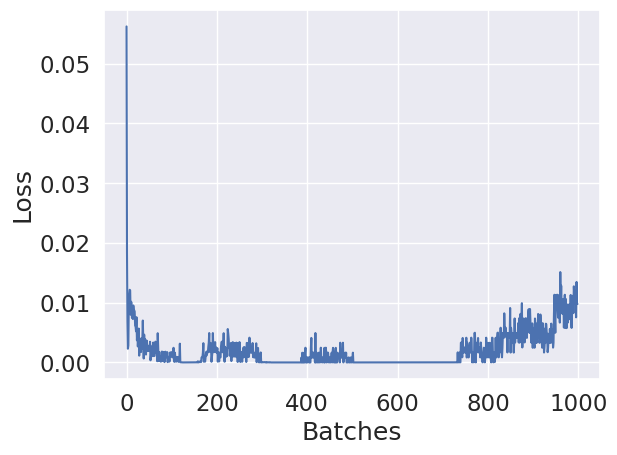

In [26]:
fig, ax = plt.subplots()
ax.plot(meanError)
ax.set(ylabel="Loss")
ax.set(xlabel="Batches")
fig.patch.set_alpha(0)
fig.patch.set_facecolor("white")
plt.savefig(plotting.PLOTS_PATH / "Loss.png", bbox_inches="tight")
plt.show()